# Ход работы

С помощью функций языка программирования Python реализована экспертная система с нечёткой логикой, оценивающая источники бесперебойного питания по трём параметрам:

- `power` - эффективная мощность (Вт)
- `time` - время бесперебойной работы (мин)
- `noise` - уровень шума (дБ)

## Импорты

In [189]:
from dataclasses import dataclass
from typing import Dict

import matplotlib.pyplot as plt
import numpy
import pandas

## Моделирование нечёткой логики

In [190]:
@dataclass
class FuzzyRule:
    """Правило принадлежности в словесной форме"""

    values: Dict[str, str]
    output: str


@dataclass 
class FuzzyTrap:
    """Функтор, содержащий параметры трапециедальной функции принадлежности"""

    a: float
    b: float
    c: float
    d: float

    def __call__(self, x: float) -> float:
        return max(
            min(
                (x - self.a) / (self.b - self.a),
                1,
                (self.d - x) / (self.d - self.c)
            ),
            0
        )

    def plot(self, begin, end):
        x = numpy.arange(begin, end, 0.001)
        y = numpy.vectorize(self, otypes=[float])(x)
        plt.plot(x, y)


@dataclass
class FuzzyMembership:
    """Функтор, вычисляющий группу, к которой принадлежит входное значение"""

    items: Dict[str, FuzzyTrap]
    display: str

    @property
    def left(self) -> float:
        return min((t.a for t in self.items.values()))

    @property
    def right(self) -> float:
        return max((t.d for t in self.items.values()))

    def __call__(self, input: float) -> str:
        left, right = self.left, self.right

        if input <= left:
            return min(self.items.items(), key=lambda i: i[1].a)[0]
        elif input >= right:
            return max(self.items.items(), key=lambda i: i[1].d)[0]
        else:
            return max(self.items.items(), key=lambda i: i[1](input))[0]


    def plot(self) -> None:
        left, right = self.left, self.right
        offset = (right - left) * 0.02
        left, right = left - offset, right + offset
        plt.xlim(left, right)
        plt.ylim(-0.05, 1.05)

        for item in self.items.values():
            item.plot(left, right)

        plt.xlabel(self.display)
        plt.show()

## Специализация модели нечёткой логики для источников питания

In [191]:
@dataclass
class PowerSupplyMembers:
    """Результат вычисления функций принадлежности для каждого параметра источника питания"""
    power: str
    time: str
    noise: str

    def rule(self, output) -> FuzzyRule:
        """Создать новое правило по оценкам параметров"""
        return FuzzyRule(values=self.__dict__, output=output)

    def matches(self, rule: FuzzyRule) -> bool:
        """Проверить, подходят ли значения к правилу"""
        return self.__dict__ == rule.values


@dataclass
class PowerSupplyMembership:
    """Функтор, преобразующий набор параметров ИБП в набор оценок параметров"""

    power: FuzzyMembership
    time:  FuzzyMembership
    noise: FuzzyMembership

    def __call__(self, supply: PowerSupply) -> PowerSupplyMembers:
        return PowerSupplyMembers(
            power=self.power(supply.power),
            time =self.time(supply.time),
            noise=self.noise(supply.noise),
        )

    def plot(self):
        self.power.plot()
        self.time.plot()
        self.noise.plot()


@dataclass
class PowerSupply:
    """Параметры ИБП"""
    name: str

    power: float
    time: float
    noise: float

## Определение функторов принадлежности для ИБП

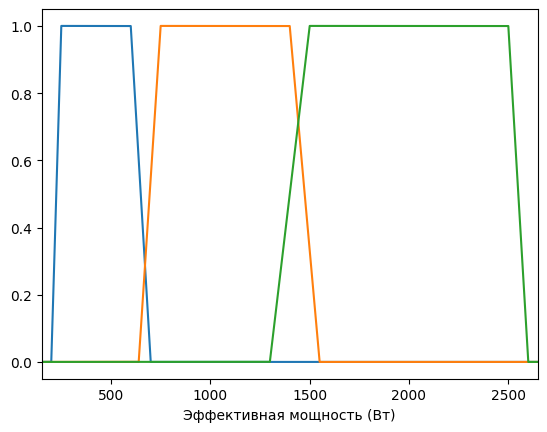

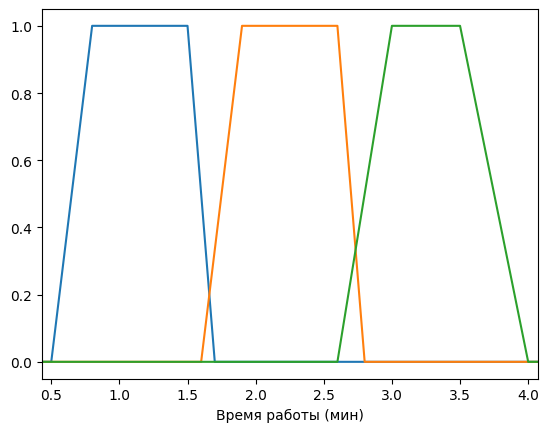

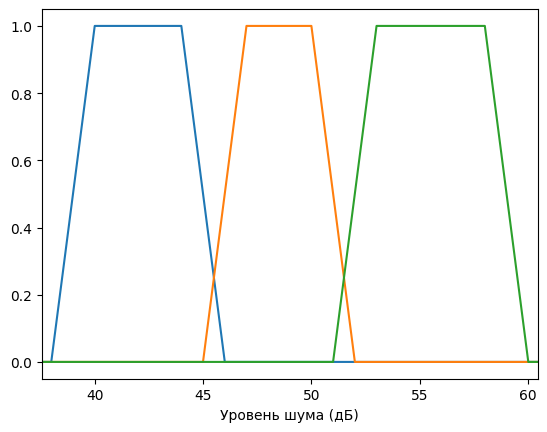

In [192]:
supply_membership = PowerSupplyMembership(
    power=FuzzyMembership(
        items={
            "low"   : FuzzyTrap(200, 250, 600, 700),
            "medium": FuzzyTrap(640, 750, 1400, 1550),
            "high"  : FuzzyTrap(1300, 1500, 2500, 2600),
        },
        display="Эффективная мощность (Вт)"
    ),
    time=FuzzyMembership(
        items={
            "short" : FuzzyTrap(0.5, 0.8, 1.5, 1.7),
            "medium": FuzzyTrap(1.6, 1.9, 2.6, 2.8),
            "long"  : FuzzyTrap(2.6, 3.0, 3.5, 4.0),
        },
        display="Время работы (мин)"
    ),
    noise=FuzzyMembership(
        items={
            "quiet" : FuzzyTrap(38, 40, 44, 46),
            "medium": FuzzyTrap(45, 47, 50, 52),
            "loud"  : FuzzyTrap(51, 53, 58, 60),
        },
        display="Уровень шума (дБ)"
    )
)

supply_membership.plot()

## Определение набора правил для составления итоговой оценки ИБП

In [193]:
supply_rules = [
    PowerSupplyMembers(power="low",    time="short",  noise="loud"  ).rule("low"   ),
    PowerSupplyMembers(power="low",    time="short",  noise="medium").rule("low"   ),
    PowerSupplyMembers(power="low",    time="short",  noise="quiet" ).rule("low"   ),
    PowerSupplyMembers(power="low",    time="medium", noise="loud"  ).rule("low"   ),
    PowerSupplyMembers(power="low",    time="medium", noise="medium").rule("low"   ),
    PowerSupplyMembers(power="low",    time="medium", noise="quiet" ).rule("medium"),
    PowerSupplyMembers(power="low",    time="long",   noise="loud"  ).rule("low"   ),
    PowerSupplyMembers(power="low",    time="long",   noise="medium").rule("medium"),
    PowerSupplyMembers(power="low",    time="long",   noise="quiet" ).rule("medium"),

    PowerSupplyMembers(power="medium", time="short",  noise="loud"  ).rule("low"   ),
    PowerSupplyMembers(power="medium", time="short",  noise="medium").rule("medium"),
    PowerSupplyMembers(power="medium", time="short",  noise="quiet" ).rule("medium"),
    PowerSupplyMembers(power="medium", time="medium", noise="loud"  ).rule("medium"),
    PowerSupplyMembers(power="medium", time="medium", noise="medium").rule("medium"),
    PowerSupplyMembers(power="medium", time="medium", noise="quiet" ).rule("high"  ),
    PowerSupplyMembers(power="medium", time="long",   noise="loud"  ).rule("medium"),
    PowerSupplyMembers(power="medium", time="long",   noise="medium").rule("high"  ),
    PowerSupplyMembers(power="medium", time="long",   noise="quiet" ).rule("high"  ),

    PowerSupplyMembers(power="high",   time="short",  noise="loud"  ).rule("medium"),
    PowerSupplyMembers(power="high",   time="short",  noise="medium").rule("medium"),
    PowerSupplyMembers(power="high",   time="short",  noise="quiet" ).rule("medium"),
    PowerSupplyMembers(power="high",   time="medium", noise="loud"  ).rule("medium"),
    PowerSupplyMembers(power="high",   time="medium", noise="medium").rule("high"  ),
    PowerSupplyMembers(power="high",   time="medium", noise="quiet" ).rule("high"  ),
    PowerSupplyMembers(power="high",   time="long",   noise="loud"  ).rule("high"  ),
    PowerSupplyMembers(power="high",   time="long",   noise="medium").rule("high"  ),
    PowerSupplyMembers(power="high",   time="long",   noise="quiet" ).rule("high"  ),
]

## Определение экспертной системы с нечёткой логикой

In [194]:
def get_output_by_rule(supply) -> str:
    members = supply_membership(supply)

    for rule in supply_rules:
        if members.matches(rule):
            return rule.output

    raise ValueError(f"No rule for {supply}")

## Тестирование

In [ ]:
supplies = [
    PowerSupply("DEXP CEE-E 1500VA",              900,  5,   45),
    PowerSupply("DEXP IEC Plus ONLINE 3000VA",    2700, 5,   50),
    PowerSupply("DEXP CEE-E 650VA",               390,  10,  45),
    PowerSupply("CyberPower UT1100EG",            660,  1,   60),
    PowerSupply("Ippon Smart Winner II 3000",     2700, 5,   45),
    PowerSupply("FSP Champ TW 3K",                2700, 5,   60),
    PowerSupply("APC Smart-UPS SRT RM 6000VA",    6000, 2.5, 55),
    PowerSupply("FSP FP1500 CEE",                 900,  6.5, 40),
    PowerSupply("CyberPower UTC850E",             425,  2,   40),
    PowerSupply("Powercom Raptor RPT-1500AP LCD", 900,  2,   40),
    PowerSupply("Ippon Back Verso 800",           420,  1.5, 45),
]

ratings = [get_output_by_rule(s) for s in supplies]

pandas.DataFrame(data=[s.__dict__ | {"rating": r} for s, r in zip(supplies, ratings)])

,name,power,time,noise,rating
0,DEXP CEE-E 1500VA,900,5.0,45,high
1,DEXP IEC Plus ONLINE 3000VA,2700,5.0,50,high
2,DEXP CEE-E 650VA,390,10.0,45,medium
3,CyberPower UT1100EG,660,1.0,60,low
4,Ippon Smart Winner II 3000,2700,5.0,45,high
5,FSP Champ TW 3K,2700,5.0,60,high
6,APC Smart-UPS SRT RM 6000VA,6000,2.5,55,medium
7,FSP FP1500 CEE,900,6.5,40,high
8,CyberPower UTC850E,425,2.0,40,medium
9,Powercom Raptor RPT-1500AP LCD,900,2.0,40,high
